# Applied Data Science Capstone

## 'This is so New York!!!' 

### 1. Introduction

#### Everyone has heard the following phrase: 'This is so New York!!'. Or maybe saying it about another famous city in the heard. Maybe you heard it when someone just saw something that remembers this person of New York.  Of course, this can happen to almost everything! However, there is some quite unique places in New York City, isn´t? But, actually, are there characteristics of New York that distinguish it from other cities? Like Toronto, perhaps?

#### We are going to try to answer that question by using some foursquare data, such as restaurants, coffee places, etc! We are going to use some machine learning algorithms trying to extract the characteristics that defines it city in order to classify each Neighbourhood as belonging to Toronto or New York. If our models succeed to do it so, there are characteristics that defines each city, and, actually, it is correct to say 'This is so New York!!'. In the other hand, if our models fails to classify each Neighbourhood, we can say that both cities are very similar!


### 2. Data

#### We are going to use data from the past labs of the Applied Data Science Capstone Course. These data contain the coordinates of each Neighbourhood and the corresponding Borough. Then, we will use maps provided by the Folium package to illustrate these Neighbourhoods.

#### Moreover, we are going to use the Foursquare API to fetch data about venues, such as restaurants, museums and shops. These data will be the features of each sample to our model!

#### So, our final dataset will contain one hot enconded venues categories with the corresponding neighborhood!


Let's import some useful packages:

In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import folium # plotting library

print('Imported!')

### Data prepocessing and overview

Firstly, we need to import previously used data of both cities, New York and Toronto! These data contains the neighborhood name and its corresponding Borough, Latitude and Longitude.

In [ ]:
toronto = pd.read_csv('toronto_data.csv', index_col=0)
new_york = pd.read_csv('manhattan_data.csv', index_col=0)

Below we can see our data and how it is structured:

In [49]:
print('We have',toronto.shape[0],'neighborhoods!')
toronto.head()

We have 39 neighborhoods!


,Borough,Neighborhood,Latitude,Longitude
0,East Toronto,The Beaches,43.676357,-79.293031
1,East Toronto,"Riverdale, The Danforth West",43.679557,-79.352188
2,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,East Toronto,Studio District,43.659526,-79.340923
4,Central Toronto,Lawrence Park,43.728020,-79.388790


In [50]:
print('We have',new_york.shape[0],'neighborhoods!')
new_york.head()

We have 40 neighborhoods!


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


We have a quite balanced data set!

And, finally, using Folium's map, we can the actual location of each neighborhood of both cities:

In [128]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto['Latitude'], toronto['Longitude'], toronto['Borough'], toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [225]:
address = 'Manhattan, New York, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude

# create map of Toronto using latitude and longitude values
map_ny = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(new_york['Latitude'], new_york['Longitude'], new_york['Borough'], new_york['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
    
map_ny

#### Foursquare credentials:

In [ ]:
CLIENT_ID = 'M4OAEWZU4YKT1G4TL2IFWLWFE5W5S45EFFE0X4FVA1YHCNEC' # your Foursquare ID
CLIENT_SECRET = 'AGIBLIFO5BZRAHVIPNK31PJIWRBWHR5EHOLWFZAQREBUFBUQ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Let´s use the provided function to get nearby venues of a given coordinate!

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
toronto_venues = getNearbyVenues(names=toronto['Borough'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )
print('Finished!')

Now that we have fetched venues data, we merge our location data into it, and take a look of how it is structured:

In [ ]:
print(toronto_venues.shape)
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

toronto_venues = toronto_venues.merge(toronto.drop('Borough',axis=1), left_on=['Borough Latitude','Borough Longitude'], right_on=['Latitude','Longitude'])
toronto_venues.drop(['Borough Latitude', 'Borough Longitude'], axis=1, inplace=True)

In [48]:
print(toronto_venues.shape)
toronto_venues.head()

(1709, 8)


,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood,Latitude,Longitude
0,East Toronto,Glen Manor Ravine,43.676821,-79.293942,Trail,The Beaches,43.676357,-79.293031
1,East Toronto,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store,The Beaches,43.676357,-79.293031
2,East Toronto,Grover Pub and Grub,43.679181,-79.297215,Pub,The Beaches,43.676357,-79.293031
3,East Toronto,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors,The Beaches,43.676357,-79.293031
4,East Toronto,Upper Beaches,43.680563,-79.292869,Neighborhood,The Beaches,43.676357,-79.293031


As we did to toronto data, we need to do to new york as well:

In [ ]:
ny_venues = getNearbyVenues(names=new_york['Neighborhood'],
                                   latitudes=new_york['Latitude'],
                                   longitudes=new_york['Longitude']
                                  )
print('Finished!')

In [ ]:
print(ny_venues.shape)
print('There are {} uniques categories.'.format(len(ny_venues['Venue Category'].unique())))

ny_venues = ny_venues.merge(new_york.drop('Borough',axis=1), left_on=['Borough Latitude','Borough Longitude'], right_on=['Latitude','Longitude'])
ny_venues.drop(['Borough Latitude', 'Borough Longitude'], axis=1, inplace=True)

In [46]:
print(ny_venues.shape)
ny_venues.head()

(3297, 8)


,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood,Latitude,Longitude
0,Marble Hill,Arturo's,40.874412,-73.910271,Pizza Place,Marble Hill,40.876551,-73.91066
1,Marble Hill,Bikram Yoga,40.876844,-73.906204,Yoga Studio,Marble Hill,40.876551,-73.91066
2,Marble Hill,Tibbett Diner,40.880404,-73.908937,Diner,Marble Hill,40.876551,-73.91066
3,Marble Hill,Starbucks,40.877531,-73.905582,Coffee Shop,Marble Hill,40.876551,-73.91066
4,Marble Hill,Dunkin',40.877136,-73.906666,Donut Shop,Marble Hill,40.876551,-73.91066


Lastly, we need to convert venues data from categorical to numerical in order to use statiscal and machine learning models! However, maybe there are particular categories of venues for each city, therefore we need to concatenate both data set prior to one hot enconding!  

But first, let's create a column label and add it to each data set:

0 = Toronto; 1 = New York.

In [53]:
label = []
for i in range(len(toronto_venues)):
    label.append(0)
    
toronto_venues.insert(8, 'Target',label)

toronto_venues.head()

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood,Latitude,Longitude,Target
0,East Toronto,Glen Manor Ravine,43.676821,-79.293942,Trail,The Beaches,43.676357,-79.293031,0
1,East Toronto,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store,The Beaches,43.676357,-79.293031,0
2,East Toronto,Grover Pub and Grub,43.679181,-79.297215,Pub,The Beaches,43.676357,-79.293031,0
3,East Toronto,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors,The Beaches,43.676357,-79.293031,0
4,East Toronto,Upper Beaches,43.680563,-79.292869,Neighborhood,The Beaches,43.676357,-79.293031,0


We can see that there is a Neighborhood category in 'Venue Category'! We need to change its name to not get mistakes after one hot enconding the dataset!

In [69]:
toronto_venues['Venue Category'].replace('Neighborhood','Neighborhood_Cat', inplace=True)

toronto_venues.head()

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood,Latitude,Longitude,Target
0,East Toronto,Glen Manor Ravine,43.676821,-79.293942,Trail,The Beaches,43.676357,-79.293031,0
1,East Toronto,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store,The Beaches,43.676357,-79.293031,0
2,East Toronto,Grover Pub and Grub,43.679181,-79.297215,Pub,The Beaches,43.676357,-79.293031,0
3,East Toronto,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors,The Beaches,43.676357,-79.293031,0
4,East Toronto,Upper Beaches,43.680563,-79.292869,Neighborhood_Cat,The Beaches,43.676357,-79.293031,0


In [54]:
label = []
for i in range(len(ny_venues)):
    label.append(1)
    
ny_venues.insert(8, 'Target',label)

ny_venues.head()

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighborhood,Latitude,Longitude,Target
0,Marble Hill,Arturo's,40.874412,-73.910271,Pizza Place,Marble Hill,40.876551,-73.91066,1
1,Marble Hill,Bikram Yoga,40.876844,-73.906204,Yoga Studio,Marble Hill,40.876551,-73.91066,1
2,Marble Hill,Tibbett Diner,40.880404,-73.908937,Diner,Marble Hill,40.876551,-73.91066,1
3,Marble Hill,Starbucks,40.877531,-73.905582,Coffee Shop,Marble Hill,40.876551,-73.91066,1
4,Marble Hill,Dunkin',40.877136,-73.906666,Donut Shop,Marble Hill,40.876551,-73.91066,1


In [70]:
venues = toronto_venues['Venue Category'].append(ny_venues['Venue Category'], ignore_index=True)
print(venues.shape)
venues.head()

(5006,)


0                   Trail
1       Health Food Store
2                     Pub
3    Other Great Outdoors
4        Neighborhood_Cat
Name: Venue Category, dtype: object

We are set to one hot enconde: 

In [71]:
venues_onehot = pd.get_dummies(venues, prefix="", prefix_sep="")
print('We have', venues_onehot.shape[1], 'different categories.')
venues_onehot.head()

We have 377 different categories.


,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Lastly, we need to have back the neighborhood and the corresponding target to our dataframe to later group by neighborhood name!

In [72]:
neighborhoods =  toronto_venues['Neighborhood'].append(ny_venues['Neighborhood'], ignore_index=True)
neighborhoods.shape

(5006,)

In [73]:
targets =  toronto_venues['Target'].append(ny_venues['Target'], ignore_index=True)
targets.shape

(5006,)

In [74]:
venues_onehot.insert(0, 'Neighborhood', neighborhoods)
venues_onehot.insert(1, 'Target', targets)

venues_onehot.head()

,Neighborhood,Target,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
neighborhoods = venues_onehot.groupby('Neighborhood').mean().reset_index()

print(neighborhoods.shape)
neighborhoods.head()

(79, 379)


,Neighborhood,Target,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, Richmond, King",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.01,0.000000,0.0,0.010000,0.00
1,Battery Park City,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.030928,0.0,0.030928,0.00
2,Berczy Park,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00
4,Carnegie Hill,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.02,0.0,0.0,0.0,0.01,0.030000,0.0,0.010000,0.03


Since we have the labels of each city, we can fetch data using it:

In [140]:
toronto_onehot = neighborhoods[neighborhoods['Target'] == 0].reset_index(drop=True)

toronto_onehot.head()

,Neighborhood,Target,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, Richmond, King",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.01,0.000000
1,Berczy Park,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000
2,Business Reply Mail Processing Centre 969 Eastern,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000
3,Central Bay Street,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.011905,0.0,0.0,0.00,0.011905
4,Christie,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000


In [141]:
ny_onehot = neighborhoods[neighborhoods['Target'] == 1].reset_index(drop=True)

ny_onehot.head()

,Neighborhood,Target,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.030928,0.0,0.030928,0.00
1,Carnegie Hill,1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.02,0.0,0.0,0.0,0.01,0.030000,0.0,0.010000,0.03
2,Central Harlem,1,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00
3,Chelsea,1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.020000,0.0,0.010000,0.00
4,Chinatown,1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.02,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00


### 3. Methodology

#### The methodology section is divided into two sections: (1) high dimensional data visualization and (2) machine learning modeling.

#### In the first section, we will use k-Means to clustering the neighborhoods of each city separately. Then, we will use a couple of unsupervised statistical approaches, PCA and t-SNE, to visualise these high dimensional data in a two dimensional plot in order to see how the clusters and data are related in the original high dimensional space. 

#### Meanwhile, in the second section, we will use Decision Tree to classify each neighborhood as belonging to New York or Toronto. Then, we will use Jaccard Score and F1 Score to evaluate our model. Finally, we will see the final tree to identify the characteristics of each city. But, prior to Decision Tree modeling, we will perform a Linear Discrimant Analysis to see wether the samples are linear separable or not!

### 3.1 High Dimensional Data Visualization

#### The Principal Component Analysis is a procedure for reducing the dimensionality of the variable space by representing it with a few orthogonal (uncorrelated) variables that capture most of its variability. In other words, it seeks to find relationship of the features. If the relationship between the feature of our data is linear, thus having a linear structure, then the principal components may explain the original variance of the data.

#### However, in some cases, the structure of the dataset is non-linear, leading to the use o manifold learning algorithms. We are going to use the state-of-the-art t-distributed Stochastic Neighbor Embedding algorithm. The t-SNE models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.

In [97]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.cm as cm
import matplotlib.colors as colors

First we are going to analyse toronto data by clustering it: 

In [143]:
toronto_onehot.drop(['Neighborhood','Target'], axis=1, inplace=True)

In [144]:
distortions = []

K = range(1,20)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(toronto_onehot)
    distortions.append(kmean.inertia_)

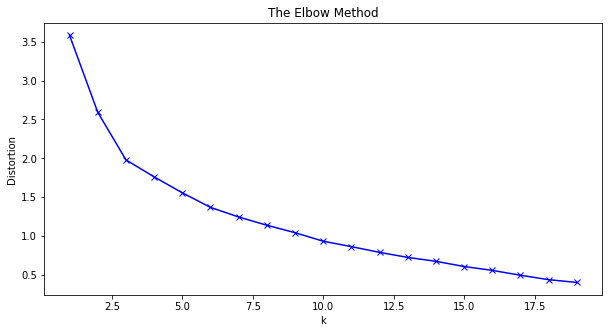

In [92]:
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

By the elbow method we determine K as equal to 3!

In [133]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_onehot)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [117]:
toronto_merged = pd.read_csv('toronto_merged.csv')

Visualizing clusters in the Toronto city:

In [132]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude

In [130]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

Now, we are going to use PCA and t-SNE to visualize the data in a two dimensional plot:

In [150]:
pca = PCA(n_components = 3).fit(toronto_onehot)
pca_toronto = pca.transform(toronto_onehot)
print("Explained variance by each component (%): ","\n1º:", pca.explained_variance_ratio_[0]*100,"\n2º:", pca.explained_variance_ratio_[1]*100,"\n3º:",pca.explained_variance_ratio_[2]*100)

Explained variance by each component (%):  
1º: 27.834915705017437 
2º: 19.152641642563527 
3º: 7.022372237397157


This suggests that our data are not linear related. However, let's plot it:

We will divide the data based on the corresponding cluster!

In [168]:
c0 = []
c1 = []
c2 = []

for i in range(len(pca_toronto)):
    if kmeans.labels_[i] == 0:
        c0.append(pca_toronto[i])
    if kmeans.labels_[i] == 1:
        c1.append(pca_toronto[i])
    if kmeans.labels_[i] == 2:
        c2.append(pca_toronto[i])
        
c0 = np.array(c0)
c1 = np.array(c1)
c2 = np.array(c2)

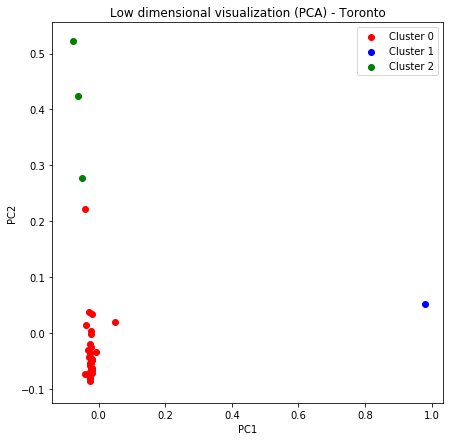

In [169]:
plt.figure(figsize=(7,7))
plt.scatter(c0[:,0], c0[:,1], c='red', label='Cluster 0')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='Cluster 1')
plt.scatter(c2[:,0], c2[:,1], c='green', label='Cluster 2')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Low dimensional visualization (PCA) - Toronto');

Although the principal components does not explain a lot of the data variance, it was able to 'capture' each cluster in the original space (379 dimensions) to illustrate it in a 2D plot.

Let's do it again, but using t-SNE:

In [163]:
tsne = TSNE(n_components=2, init='pca', perplexity = 10)
tsne_toronto = tsne.fit_transform(toronto_onehot)

Separating the data again...

In [170]:
c0 = []
c1 = []
c2 = []

for i in range(len(pca_toronto)):
    if kmeans.labels_[i] == 0:
        c0.append(tsne_toronto[i])
    if kmeans.labels_[i] == 1:
        c1.append(tsne_toronto[i])
    if kmeans.labels_[i] == 2:
        c2.append(tsne_toronto[i])
        
c0 = np.array(c0)
c1 = np.array(c1)
c2 = np.array(c2)

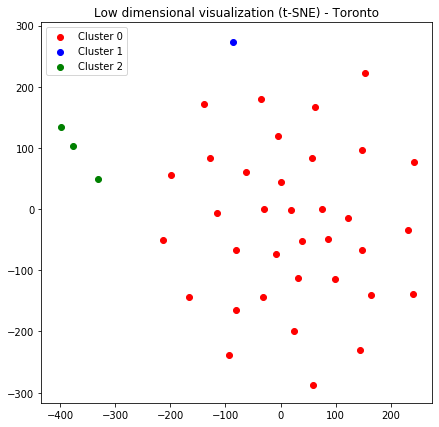

In [171]:
plt.figure(figsize=(7,7))
plt.scatter(c0[:,0], c0[:,1], c='red', label='Cluster 0')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='Cluster 1')
plt.scatter(c2[:,0], c2[:,1], c='green', label='Cluster 2')
plt.legend()
plt.title('Low dimensional visualization (t-SNE) - Toronto');

Using t-SNE, we were able to visualise each cluster as well. However, the cluster 0 was poorly illustrated.

Therefore, the visualization provided by PCA was much better!! We can see in the PCA plot that there is a sample from cluster 0 that might me considerated an outlier, since its closer to cluster 2 than to cluster 0!

Now we do this all again, but using New York data!

In [173]:
ny_onehot.drop(['Neighborhood','Target'], axis=1, inplace=True)

In [174]:
distortions = []

K = range(1,20)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(ny_onehot)
    distortions.append(kmean.inertia_)

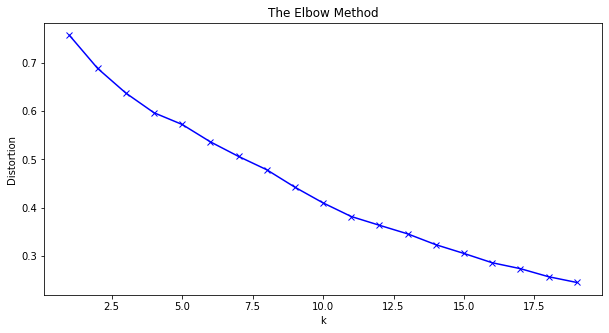

In [175]:
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

Not much helpful, let's use k = 5.

In [190]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_onehot)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [177]:
manhattan_merged = pd.read_csv('manhattan_merged.csv')

In [182]:
address = 'Manhattan, New York, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude

In [191]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

In [192]:
pca = PCA(n_components = 3).fit(ny_onehot)
pca_ny = pca.transform(ny_onehot)
print("Explained variance by each component (%): ","\n1º:", pca.explained_variance_ratio_[0]*100,"\n2º:", pca.explained_variance_ratio_[1]*100,"\n3º:",pca.explained_variance_ratio_[2]*100)

Explained variance by each component (%):  
1º: 11.199882080501379 
2º: 9.866347766942791 
3º: 8.06214502441477


The PCA performed poorly in New York! Worse than in Toronto! Let's see how it illustrate our data:

In [195]:
c0 = []
c1 = []
c2 = []
c3 = []
c4 = []

for i in range(len(pca_ny)):
    if kmeans.labels_[i] == 0:
        c0.append(pca_ny[i])
    if kmeans.labels_[i] == 1:
        c1.append(pca_ny[i])
    if kmeans.labels_[i] == 2:
        c2.append(pca_ny[i])
    if kmeans.labels_[i] == 3:
        c3.append(pca_ny[i])
    if kmeans.labels_[i] == 4:
        c4.append(pca_ny[i])
        
c0 = np.array(c0)
c1 = np.array(c1)
c2 = np.array(c2)
c3 = np.array(c3)
c4 = np.array(c4)

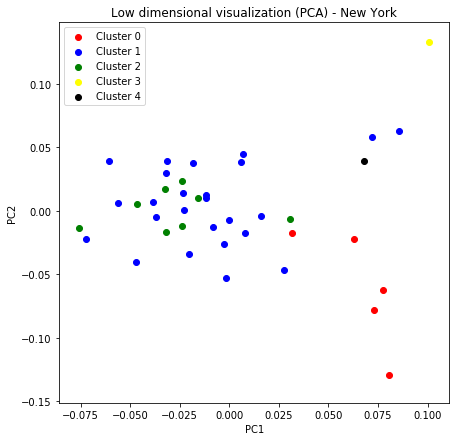

In [196]:
plt.figure(figsize=(7,7))
plt.scatter(c0[:,0], c0[:,1], c='red', label='Cluster 0')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='Cluster 1')
plt.scatter(c2[:,0], c2[:,1], c='green', label='Cluster 2')
plt.scatter(c3[:,0], c3[:,1], c='yellow', label='Cluster 3')
plt.scatter(c4[:,0], c4[:,1], c='black', label='Cluster 4')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Low dimensional visualization (PCA) - New York');

Not good! We can see that clusters 1 and 2 are overlapped. Moreover, cluster 1 seems to have two outliers!

We shall try the low dimensional representation with t-SNE now:

In [222]:
tsne = TSNE(n_components=2, init='pca', perplexity = 19)
tsne_ny = tsne.fit_transform(ny_onehot)

In [223]:
c0 = []
c1 = []
c2 = []
c3 = []
c4 = []

for i in range(len(tsne_ny)):
    if kmeans.labels_[i] == 0:
        c0.append(tsne_ny[i])
    if kmeans.labels_[i] == 1:
        c1.append(tsne_ny[i])
    if kmeans.labels_[i] == 2:
        c2.append(tsne_ny[i])
    if kmeans.labels_[i] == 3:
        c3.append(tsne_ny[i])
    if kmeans.labels_[i] == 4:
        c4.append(tsne_ny[i])
        
c0 = np.array(c0)
c1 = np.array(c1)
c2 = np.array(c2)
c3 = np.array(c3)
c4 = np.array(c4)

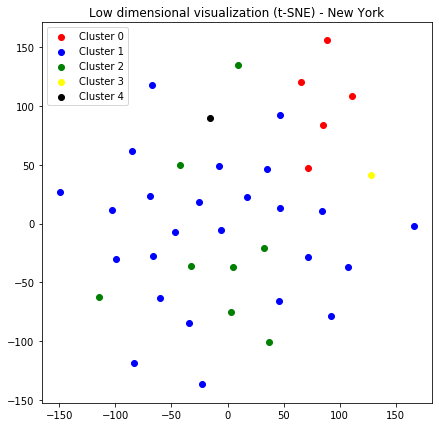

In [224]:
plt.figure(figsize=(7,7))
plt.scatter(c0[:,0], c0[:,1], c='red', label='Cluster 0')
plt.scatter(c1[:,0], c1[:,1], c='blue', label='Cluster 1')
plt.scatter(c2[:,0], c2[:,1], c='green', label='Cluster 2')
plt.scatter(c3[:,0], c3[:,1], c='yellow', label='Cluster 3')
plt.scatter(c4[:,0], c4[:,1], c='black', label='Cluster 4')
plt.legend()
plt.title('Low dimensional visualization (t-SNE) - New York');

We can see that cluster 1 and 2 are overlapped again! This suggests that k-Means are not performing well in the New York dataset! Maybe DBSCAN solves that problem, but we are not investigating it further...

Moreover, both algorithms, PCA and t-SNE, are heavily impacted by the number of samples and number of features. When the former is much smaller than the latter, we have the so-called Curse of Dimensionality! Since we have 379 features for 40 samples, we are suffering from this problem!

### 3.2 Machine Learning Modeling

#### First we will apply the Linear Discrimant Analysis, LDA for short, in order to visualise the discrimance among sample groups in a low dimensional space. This method is very similiar to PCA, however, LDA seeks to identify to each direction sample groups are better separated!

#### Then, we will use Decision Trees to classify our dataset!

In [234]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import graphviz
from scipy.stats import norm

Our modelling will use all of our data, both New York and Toronto!

Remembering that... 0 = Toronto and 1 = New York.

In [227]:
neighborhoods.head()

,Neighborhood,Target,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, Richmond, King",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.01,0.000000,0.0,0.010000,0.00
1,Battery Park City,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.030928,0.0,0.030928,0.00
2,Berczy Park,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00
3,Business Reply Mail Processing Centre 969 Eastern,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00
4,Carnegie Hill,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.02,0.0,0.0,0.0,0.01,0.030000,0.0,0.010000,0.03


In [230]:
targets = neighborhoods[['Target']]

targets.head()

,Target
0,0
1,1
2,0
3,0
4,1


In [231]:
neighborhoods.drop(['Neighborhood','Target'], axis=1, inplace=True)